# Client: Coffee King
# Dataset: Yelp Dataset

## Questions
1. Where are most coffee businesses located and which locations could be most promising for our coffee business?
2. What are the operating hours of businesses related to our client?
3. Which factors are important to customers based on reviews?
4. What differentiates lower rated from higher rated coffee businesses?
5. Which services are the most important to provide to customers?
6. Are reviews mostly positive or negative?


## Hypothesis
1. The more reviews a business has, the more stars it will have
2. Business star ratings are in align with reviews star ratings


## Approach
1. Design a map and explore business properties based on their location.
2. Explore the distribution of businesses' operating hours. 
3. Explore correlation between number of reviews and overall business star rating
4. Find business attributes that  are most common across businesses and thus most important.
5. Explore words that are frequently discussed in reviews.
6. Apply topic modelling algorithm to extract useful topics from reviews.
7. Apply sentiment analysis on reviews.


In [4]:
#Import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import requests
import os
from dotenv import load_dotenv
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from itertools import combinations
from folium.plugins import HeatMap
from geopy.distance import geodesic
from wordcloud import WordCloud
from textblob import TextBlob
from pandasql import sqldf

# Define a reusable function for running SQL queries
pysqldf = lambda q: sqldf(q, globals())


load_dotenv()

True

### Define functions to import and export data

In [5]:
# Function to get csv file from AWS s3 bucket
def get_s3_csv(file_key):
    
    # Fetch credentials to access AWS s3 bucket
    AWS_S3_BUCKET = os.getenv('AWS_S3_BUCKET')
    AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
    AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')

    # Construct the full S3 path
    s3_path = f's3://{AWS_S3_BUCKET}/{file_key}'

    # Read the csv file from S3 directly into a pandas DataFrame
    df = pd.read_csv(s3_path,  storage_options= {
        "key": AWS_ACCESS_KEY_ID,
        "secret": AWS_SECRET_ACCESS_KEY
         })

    return df

# Function to convert pandas dataframe to csv and write the file to S3
def export_csv_to_S3(df, file_key):

    # Fetch credentials to access AWS s3 bucket
    AWS_S3_BUCKET = os.getenv('AWS_S3_BUCKET')
    AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
    AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')

     # Construct the full S3 path
    s3_path = f's3://{AWS_S3_BUCKET}/{file_key}'

    df.to_csv(s3_path, index=False, storage_options={
        "key": AWS_ACCESS_KEY_ID,
        "secret": AWS_SECRET_ACCESS_KEY
    })

#### Load cleaned business dataset 

In [6]:
business_path =  'YelpData/businesses.csv'

df_business = get_s3_csv(business_path)
df_business.head()

,business_id,name,city,state,latitude,longitude,stars,review_count,categories,attribute
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Coffee & Tea,BusinessParking
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Coffee & Tea,RestaurantsTakeOut
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Coffee & Tea,BikeParking
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Coffee & Tea,BusinessAcceptsCreditCards
4,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Coffee & Tea,OutdoorSeating


#### Load cleaned reviews dataset

In [5]:
reviews_path = 'YelpData/reviews.csv'

df_reviews = get_s3_csv(reviews_path)
df_reviews.head()

,business_id,review_id,user_id,review_stars,text,date
0,--epgcb7xHGuJ-4PUeSLAw,-YPSb7opc8nTWPumW5P3Qw,-VmiK2zFPDvDFYeZXLnh5A,5,This place is almost always great... It gets 5...,2013-03-24 04:56:48
1,--epgcb7xHGuJ-4PUeSLAw,2Lq7CZnyQq5uA_H_qhd-pQ,WPJA9X2FUM_KgEMUToSpYw,5,this place continues to impress me. i stop in ...,2012-01-25 00:53:54
2,--epgcb7xHGuJ-4PUeSLAw,2gxy9uEh00D_przEth7VfA,qdHRpSbLkkNmL_4xHlms7Q,5,"The staff is friendly! Food is great, coffee i...",2016-08-27 23:46:21
3,--epgcb7xHGuJ-4PUeSLAw,2zrp_GcCx6RPkRURkmvkPA,QNO_NFL1oDX1ntvaXooV6w,1,"I was a regular costumer, till today. I ordere...",2015-03-07 14:33:38
4,--epgcb7xHGuJ-4PUeSLAw,3XIEGJo2iaZzEMST74y-AA,uv9f_lt1306GNF1zvkZGTA,1,"Worst bagels I've ever had, the place is dirty...",2013-11-18 19:15:29


### Let's explore the correlation between star rating and number of reviews

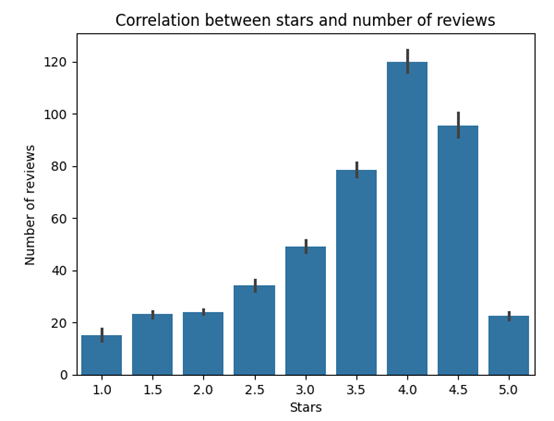

#### It seems that for businesses up to 4 stars the more stars a business has, the more reviews it has. We will check if there is a correlation between the two variables using the Spearman Rank Correlation.

1. Spearman Rank Correlation: 0.09261447073354838
2. P-Value: 1.357600026229779e-110

#### Conclusions
1. The p-value is less than 0.05 which means that correlation is statistically significant
2. The Spearman Rank Correlation is very close to 0 but larger that 0, which indicates a positive monotonic but vey weak ralationship between the stars and number of reviews a business has. 

### Now let's explore average opening and closing hours for weekdays and weekend considering four business categories that are closer to our coffee company.

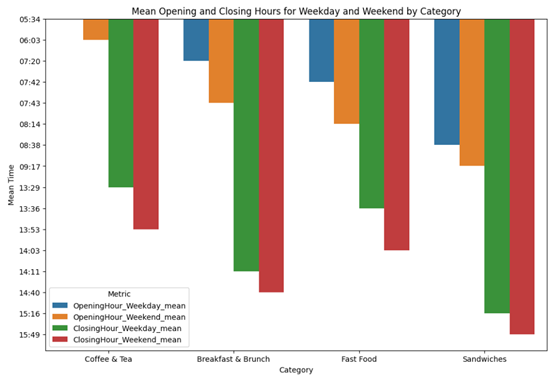

#### We can see that businesses start operating later at the weekend so they close later. 

In [6]:
q = """
SELECT business_id, name ,city, state, latitude, longitude, stars, categories
FROM df_business
WHERE categories = "Coffee & Tea"
GROUP BY business_id, categories
"""
df_business_unique = pysqldf(q)
df_business_unique.head()

,business_id,name,city,state,latitude,longitude,stars,categories
0,-0gRYq5UjMtZbELj0KHxzA,La Colombe Coffee,Bryn Mawr,PA,40.023408,-75.320947,3.5,Coffee & Tea
1,-0iIxySkp97WNlwK66OGWg,Truckee Bagel Company - Midtown,Reno,NV,39.520240,-119.810022,3.5,Coffee & Tea
2,-2BDt9OdGiBONysWCdKgNg,Dunkin',Temple Terrace,FL,28.032926,-82.396647,3.0,Coffee & Tea
3,-2dvQxx3cYXd5XmFdDDsDA,illy Caffè,Tampa,FL,27.979943,-82.538197,2.5,Coffee & Tea
4,-3-6BB10tIWNKGEF0Es2BA,The 81 Hong Kong Cafe,Tucson,AZ,32.288540,-110.963144,4.0,Coffee & Tea


In [7]:
df_business_unique.shape[0]

4954

### We have 4954 coffee businesses in total.

##### We will group the business stars into bins to create star categories. This is a new column in our business dataframe called <code>star_group</code>

In [8]:
# Define bin edges and labels
bin_edges = [1,2,3,4,5, float('inf')]
bin_labels = ['1-2', '2-3', '3-4', '4-5', '5']

In [9]:
# Create the 'star_group' column using pd.cut
df_business_unique['star_group'] = pd.cut(df_business_unique['stars'], bins=bin_edges, labels=bin_labels, 
                                         include_lowest=True, right=False)

##### Each business has many different review stars. We will calculate the average review stars  each business has and display the results in a new dataframe called <code>df_avg_review_stars</code>

In [11]:
# Sql statement to calculate average review stars for each business
q = """
SELECT business_id, ROUND(AVG(review_stars),1) AS average_review_stars
FROM df_reviews
GROUP BY business_id
"""
df_avg_review_stars = pysqldf(q)
df_avg_review_stars.head()

,business_id,average_review_stars
0,--epgcb7xHGuJ-4PUeSLAw,2.9
1,--lqIzK-ZVTtgwiQM63XgQ,1.9
2,-09Oc2D14vRnmirPh0vlXw,3.0
3,-0TffRSXXIlBYVbb5AwfTg,4.4
4,-0gRYq5UjMtZbELj0KHxzA,3.6


##### Next, we merge the <code>df_business_unique</code> dataframe with <code>df_avg_review_stars</code> to get the average review star rating for each business star group. The aggregated results are displayed in the dataframe <code>agg_df</code>.

In [13]:
# sql statement to merge business and reviews table and calculate the average review stars for each star group
q = """
SELECT star_group, ROUND(AVG(average_review_stars),1) as avg_review_star_group
FROM (
    SELECT b.star_group, r.average_review_stars
    FROM df_business_unique AS b
    INNER JOIN df_avg_review_stars AS r
    ON b.business_id = r.business_id
)
GROUP BY star_group
"""
agg_df = pysqldf(q)
agg_df.head()

,star_group,avg_review_star_group
0,1-2,1.5
1,2-3,2.2
2,3-4,3.3
3,4-5,4.3
4,5,4.9


##### We finally plot a bar chart that displays the average review star rating for each business star category. The goal is to check if the actual star rating is in align with business star rating.

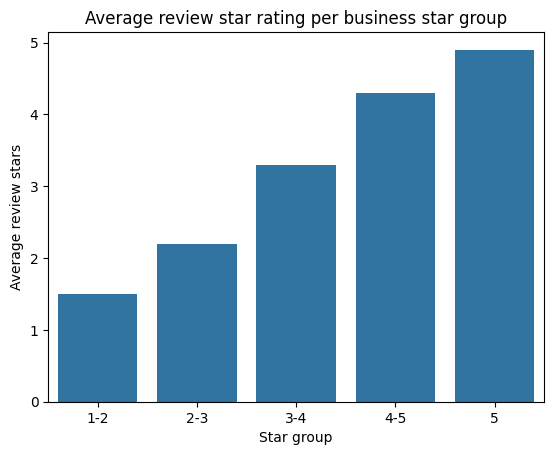

In [14]:
# Plot average review star rating for each star category using seaborn library
sns.barplot(data=agg_df, x=agg_df['star_group'], y=agg_df['avg_review_star_group'])
plt.title("Average review star rating per business star group")
plt.xlabel("Star group")
plt.ylabel("Average review stars")
plt.show()

### As wee can see, business star ratings are in align with reviews star rating

##### We want to find locations where the majority of coffee businesses are located. As a first step, we explore total coffee businesses per US state and display the results in the dataframe named <code>df_business_states</code>

In [16]:
# sql statement to count the total business located in each US state
q = """
SELECT state, COUNT(DISTINCT(business_id)) AS total_businesses
FROM df_business_unique
WHERE categories = "Coffee & Tea"
GROUP BY state
ORDER BY total_businesses DESC
"""
df_business_states = pysqldf(q)
df_business_states.head()

,state,total_businesses
0,PA,1224
1,FL,867
2,NJ,361
3,TN,358
4,IN,336


##### Next, we plot the results using a bar chart.

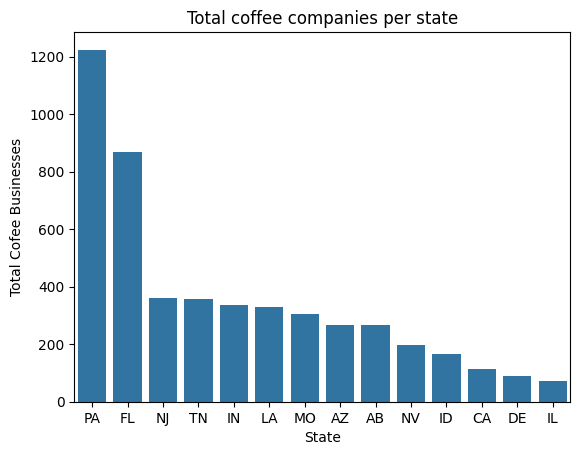

In [17]:
# Bar chart to plot total coffee businesses per US state using seaborn library
sns.barplot(data=df_business_states, x=df_business_states['state'], y=df_business_states['total_businesses'])
plt.title("Total coffee companies per state")
plt.xlabel("State")
plt.ylabel("Total Cofee Businesses")
plt.show()

### The number of coffee businesses located in states Pennsylvania and Florida is at least 100% higher than the average number of coffee businesses in a state. 

In [24]:
# sql statement to calculate the percentage difference between each state total coffee businesses and average number of coffee businesses over all states.
q= '''
WITH avg_state_business AS (
    SELECT AVG(total_businesses) AS  avg_businesses
    FROM df_business_states
)
SELECT s.state, ROUND((((s.total_businesses - a.avg_businesses)/a.avg_businesses) * 100),2) AS percent_diff 
FROM df_business_states s, avg_state_business a
'''
df_a = pysqldf(q)
df_a.head()

,state,percent_diff
0,PA,245.90
1,FL,145.01
2,NJ,2.02
3,TN,1.17
4,IN,-5.05


##### Next, we will check how cofee businesses are distributed across  different states based on their star rating.

##### At first, we plot a histogram that effectively shows the distribution of business star rating.

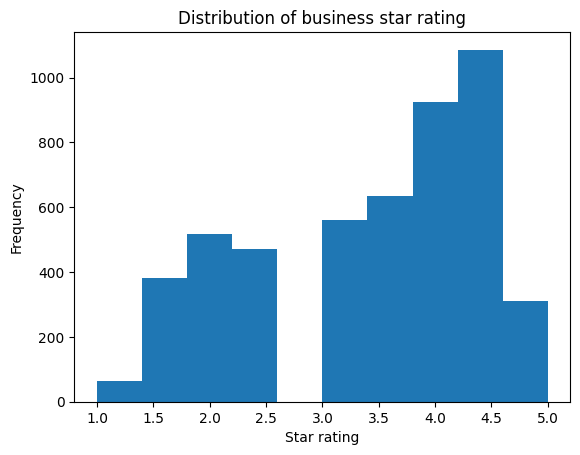

In [18]:
# plot histogram with business star rating using matplotlib library
df_business_unique['stars'].plot.hist()
plt.title('Distribution of business star rating')
plt.xlabel('Star rating')
plt.show()

### Most businesses have 4.0 to 4.5 star rating

##### Since most coffee businesses are 4.0-4.5 rated, we will calulate the weighted star rating per state to efficiently show the distribution of business star rating per state. Next, we will design a choropleth map that displays the results.

In [25]:

# Function to calculate weighted average
def weighted_average(group):
    # Count the number of businesses for each star rating in the group (per state)
    star_counts = group['stars'].value_counts()
    
    # Calculate the weighted sum of stars
    weighted_sum = np.sum(star_counts.index * star_counts.values)
    
    # Calculate the total number of businesses in that state
    total_businesses = star_counts.sum()
    
    # Calculate the weighted average
    weighted_avg = weighted_sum / total_businesses
    
    return weighted_avg.round(1)

state_ratings = df_business_unique.groupby('state').apply(weighted_average).reset_index(name='weighted_avg_stars')

center_lat = df_business_unique['latitude'].mean()
center_lon = df_business_unique['longitude'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start = 4)

state_data = requests.get("https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json").json()

folium.Choropleth(
    geo_data = state_data,
    name="choropleth",
    data=state_ratings,
    columns=['state','weighted_avg_stars'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Weighted Average Star Rating'
    
    ).add_to(m)

folium.GeoJson(
    state_data,
    name='geojson',
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
    },
    highlight_function=lambda x: {'weight': 3, 'color': 'black'},
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name'],
        aliases=['State:'],
        localize=True
    )
).add_to(m)


m

### Conclusion: It seems that coffee businesses in the following states have higher star ratings:
1. California
2. Idaho
3. Louisiana

##### Another factor that is crucial to decide whether a state is a good choice for a new coffee business to open is to check the average distance between coffee businesses in this state. The reason is that states that are filled with cafés in every corner means higher cometition than states, where the average distance between cafés is relatively long.

##### Therefore, we will calculate the average distance between coffee businesses for each state and design another choropleth map to visualize the results. 

In [26]:
# Create tuple coordinates with latitude and longitude for each business
df_business_unique['coordinates'] = list(zip(df_business_unique['latitude'], df_business_unique['longitude']))

# Calculate distances in km between all pairs of businesses per state
distances = df_business_unique.groupby('state')['coordinates'].apply(
    lambda x: [geodesic(a,b).kilometers for a,b in combinations(x,2)]).reset_index()

distances = distances.rename(columns={'coordinates':'distances'})

In [27]:
# Calculate average distance between businesses per state
distances['avg_distance'] = distances['distances'].apply(lambda x: sum(x)/len(x)).round(2)
distances.drop(columns=['distances'], axis=1, inplace=True)

In [28]:
df_business_unique.drop(columns=['coordinates'], axis=1, inplace=True)

In [29]:
# design choropleth map with average distance between coffee businesses using folium library
m = folium.Map(location=[center_lat, center_lon], zoom_start=4)

folium.Choropleth(
    geo_data = state_data,
    name="choropleth",
    data=distances,
    columns=['state','avg_distance'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average distance between businesses'
    
    ).add_to(m)

folium.GeoJson(
    state_data,
    name='geojson',
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
    },
    highlight_function=lambda x: {'weight': 3, 'color': 'black'},
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name'],
        aliases=['State:'],
        localize=True
    )
).add_to(m)

m

#### Conclusion: From the map we can see that coffee businesses that are located in one of the  following states are closer to one another, which creates higher competition:
1. Idaho
2. Nevada
3. California
4. Mississippi

#### On the other hand, coffee businesses that are located in one of the following states are at least 22 km apart on average, which allows each company to increase its revenue more easily due to lower competition.
1. Illinois
2. Pennsylvania
3. Florida

#### Our analysis so far shows that most coffee businesses are located in Pennsylvania and Florida, which are promising states for a new coffee business to open.

#### In addition to that, it seems that in terms of sheer variety and quantity of tourist attractions, Florida is often considered a top tourist destination due to its theme parks, beaches, and diverse cultural offerings. Therefore, we will further explore the coffee business located in the state of Florida, since from the analysis it is probably one of the most promising states for our coffee business to open.

##### We will calculate the percentage of businesses per city in the state of Florida and keep the top 10 cities with the higher percentages. The results are aggregated in dataframe <code>df_FL_cities</code>.

In [31]:
q = """
SELECT 
    city,
    CASE
        WHEN SUM(COUNT(*)) OVER() = 0 THEN 0
        ELSE ROUND(COUNT(*) * 100.0/SUM(COUNT(*)) OVER(),2)
    END AS percent_of_businesses
    
FROM df_business_unique
WHERE state = "FL"
GROUP BY city
ORDER BY percent_of_businesses  DESC
LIMIT 10
"""
df_FL_cities = pysqldf(q)
df_FL_cities.head()

,city,percent_of_businesses
0,Tampa,34.14
1,Saint Petersburg,6.81
2,Clearwater,6.57
3,St. Petersburg,5.31
4,Riverview,3.81


##### Next, we will display Florida cities with the top 10 highest percent of coffee businesses using a bar chart.

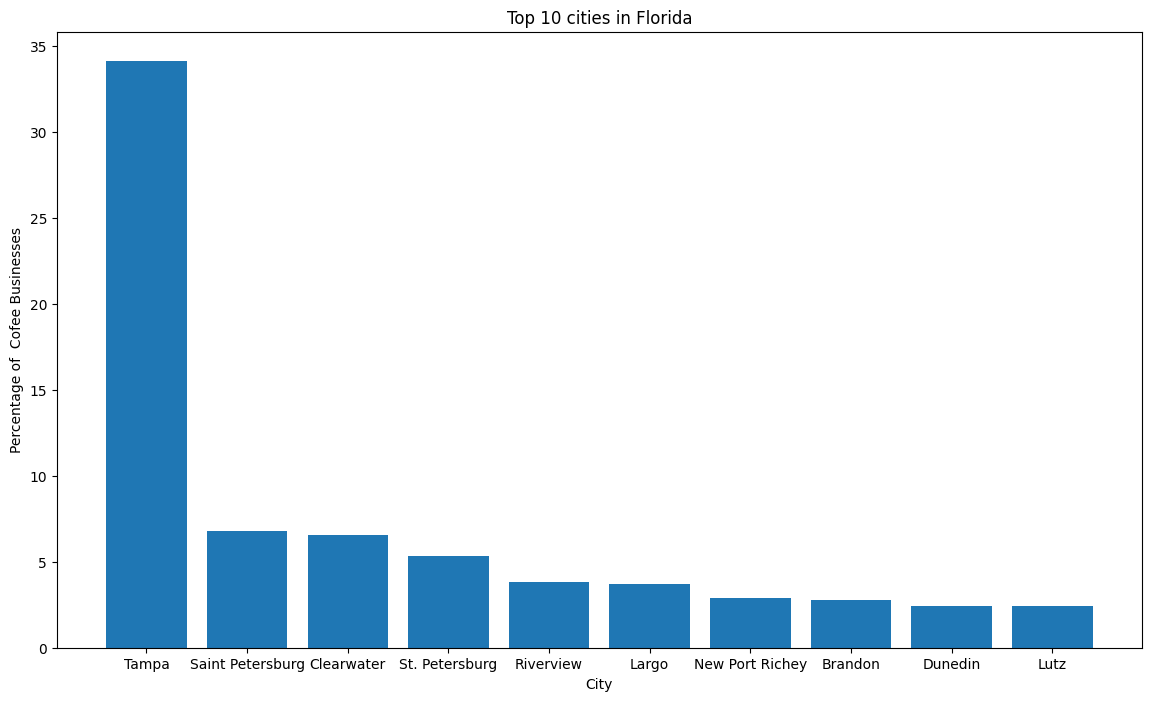

In [32]:
# Plot bar chart using matplotlib
plt.figure(figsize=(14,8))
plt.bar(df_FL_cities['city'] , df_FL_cities['percent_of_businesses'])
plt.title("Top 10 cities in Florida")
plt.xlabel("City")
plt.ylabel("Percentage of  Cofee Businesses")
plt.show()

#### It seems that 30% of the businesses in Florida are located in the city of Tampa. Furthermore, top 3 cities with the highest number of businesses are all part of the greater Tampa Bay. Let's explore the business locations in the city of Tampa even further.

#### We will select some key areas where a coffee business could open and explore the businesses that are located in those areas.

In [33]:
# Select only coffee business located in Tampa city
df_Tampa = df_business_unique[df_business_unique['city'] == "Tampa"].reset_index()

# Drop non-relevant categories 
df_Tampa.drop(columns=['index','city','state','categories'], axis=1, inplace=True)

##### We will design a choropleth map that displays the coffee businesses that are located within 1 km from each key location.

In [34]:
#Create folium map centered around Tampa
tampa_map = folium.Map(location=[27.9517, -82.4588], zoom_start=13)

#Function to assign color based on star rating
def get_marker_color(stars):
    return 'red' if stars >= 4 else 'blue'

#Function to check if a point is within circle
def is_point_in_circle(point, center, radius):
    distance = geodesic(point, center).meters
    return distance <= radius

#Check if a point is within any circle
def is_point_in_any_circle(point, circles):
    for params in circles.values():
        if is_point_in_circle(point, params['coords'], params['radius']):
            return True
    return False
    

#Key locations in Tampa
locations = {
    'Downtown tampa':{'coords':[27.94949724916548, -82.45631286588983], 'radius':1000},
    'University of South Florida(USF)':{'coords':[28.058920835949298, -82.41389681863677], 'radius': 1000},
    'Ybor City':{'coords':[27.9650212, -82.4350941], 'radius': 1000},
    'Tampa Riverwalk': {'coords':[27.94484775523052, -82.45875361679079], 'radius': 1000},
    'Hyde Park Village':{'coords':[27.937283506095774, -82.47584933531247], 'radius': 1000},
    'Tampa International Airport':{'coords':[27.977163876326877, -82.53009800144729], 'radius': 1000},
    'Channelside Bay Plaza':{'coords':[27.94304830437474, -82.44733906096896], 'radius': 1000},
    'University of Tampa':{'coords':[27.946090976991364, -82.46589073619269], 'radius': 1000},
    'WestShore Plaza': {'coords':[27.94755868357797, -82.52738450144814], 'radius': 1000},
    'Kennedy Boulevard': {'coords':[27.94503432669266, -82.49020493716037], 'radius': 1000}    
}

#Add markers for businesses inside circles
for index, row in df_Tampa.iterrows():
    for location, params in locations.items():
        if is_point_in_any_circle([row['latitude'], row['longitude']], locations):
            folium.Marker(
                location=[row['latitude'], row['longitude']],
                popup=f"<b>{row['name']} </b>({row['stars']})",
                icon = folium.Icon(get_marker_color(row['stars']))            
            ).add_to(tampa_map)
            

            
#Add circles for each key location
for location,params in locations.items():
    folium.Circle(
        location = params['coords'],
        radius = params['radius'],
        color= 'blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.2,
        popup=location   
    ).add_to(tampa_map)

tampa_map

### Insights based on key locations:

#### 1. Tampa International Airport: 
* Businesses are distibuted across the different airsides.
* There is only one coffee business located in the main Terminal, Starbucks.
* Most businesses are under 3 stars. 

#### 2. Westshore Plaza Mall:
* There are only 2 businesses inside the mall, which have at least 4 star rating.
* The rest of the business are located near the part of the West Kennedy Boulevard street that is close to the mall.

#### 3. Hyde Park Village:
* There is only one business in the center of the village and the rest of the businesses are located across avenues around the village.
* All the businesses are at least 4 stars.

#### 4. University of Tampa:
* Coffee business are located near the university.
* Most businesses are located near the West kennedy Boulevard which is 5 minutes from the UT. Those businesses are at leat 4 stars.
* There are 3 parks near the UT(Agliano Park, Delo Park and Vaughn Center Countryard), where there are is only one coffee business in total, Starbucks. 

#### 5. Tampa Riverwalk:
* Surprisingly, there are not many coffee businesses in the Tampa Riverwalk, which is a pathway along the Hillsborough River.
* Some very promising locations across the riverwalk include:
1. Curtis Hixon Waterfront Park, which is a popular gathering spot for events and recreation. There are no other businesses in the park.
2. Tampa Convention Center, where there is a number of events and conferences taking place. There is only one business close to the center, Starbucks(yes Starbucks is everywhere).
3. Straz Center for the Performing Arts: Coffee shops near cultural venues often appeal to patrons looking for a pre-show or intermission pick-me-up. There is only one coffee business there, which is 3.5 stars rated.


#### 6. Downtown Tampa:
* There are a lot of businesses based on Downtown Tampa. The majoroty of businesses are at least 4 star rated and are close to central streets.
* Some promising locations in Downtown Tampa are the following:
1. Amalie Arena:A Coffee shop near the arena can capture sports fans and concert attendees, especially on event days. There seems to be no businesses near the arena.
2. Water Street: This is a large-scale and transformative real estate development project located in downtown Tampa. Key features include high-rise residential towers, corporate offices, entertainment and cultural spaces, retail and dining options, and waterfront access along the Hillsborough River. Specifically,a  good choice could be the area around JW Marriot Tampa Water Street, a luxurious hotel which is close to Riverwalk and the Amelie Arena. Based on the map, there are some restaurants but not any coffee businesses nearby.

#### 7. Ybor   City:
* The majority of coffee shops are located across the East 7th Avenue, which is Ybor City's main commercial thoroughfare. All the businesses are at least 4 star rated. There is very high competition in this area.
* Some promising locations are the following:
1. Centennial Park: This is a historical park that hosts cultural events, festivals, or community gatherings, especially due to its historical significance. There is only one coffee business nearby, which is 3 star rated.
2. Centro Ybor: This is the Ybor City State Museum, also known as Centro Ybor and provides insights into the history and development of Ybor City. Specifically, there are some restaurants across the East 8th Avenue, which is a central road close to the museum but there are not any coffee shops.

#### 8. University of South Florida(USF):
* There are only two coffee businesses in the USF, which makes this location really promising.
* Some good locations near the USF are the following:
1. Near the Marshall Student Center (MSC): The MSC is a central hub for student activities and services. A potential coffee business nearby can attract students taking breaks between classes or studying in the center. There are a lot of restaurants and fast food businesses but no coffee shops.


### Moving on to the next step, we want to find which services are the most important to provide to customers.

#### To achive this, we will consider the business attributes that at least half of businesses have.

In [35]:
# sql statement to find business attributes that at least half of businesses have
q = """
WITH BusinessCount AS (
    SELECT COUNT(DISTINCT(business_id)) AS total_businesses
    FROM df_business
    WHERE categories = "Coffee & Tea" )
SELECT attribute, ROUND(COUNT(DISTINCT(business_id)) * 100.0/BusinessCount.total_businesses,2) AS business_percentage
FROM df_business,BusinessCount
WHERE categories = "Coffee & Tea"
GROUP BY attribute
HAVING business_percentage >= 50.00
ORDER BY business_percentage DESC
"""
df_attributes = pysqldf(q)
df_attributes.head()

,attribute,business_percentage
0,RestaurantsTakeOut,91.87
1,BusinessParking,88.76
2,WiFi,86.21
3,BusinessAcceptsCreditCards,84.96
4,RestaurantsPriceRange2,82.58


##### We plot the results using a horizontal bar chart

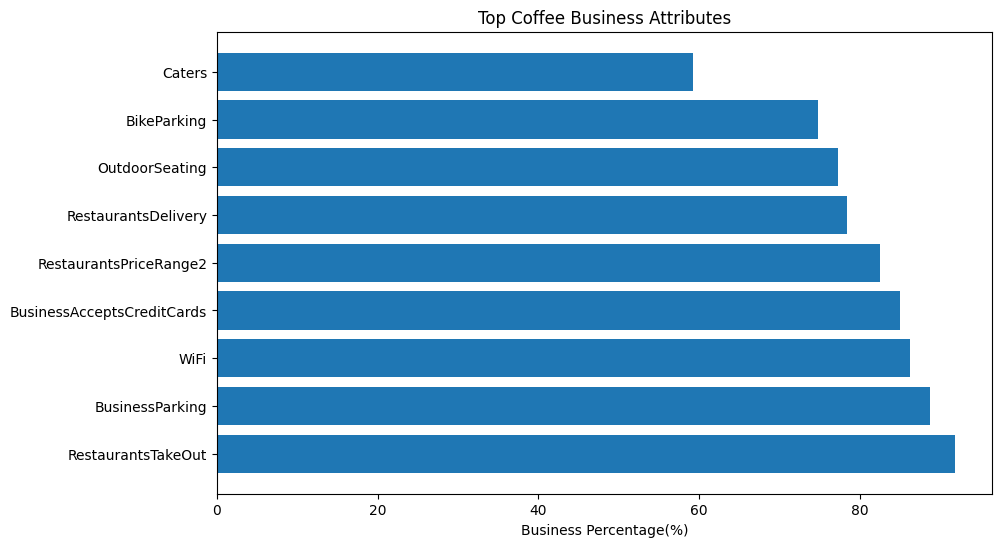

In [36]:
# plot horizontal barchart with matplotlib
plt.figure(figsize=(10,6))
plt.barh(df_attributes['attribute'], df_attributes['business_percentage'])
plt.xlabel('Business Percentage(%)')
plt.title('Top Coffee Business Attributes')
plt.show()

### Insights:
1. As wee can see, over 80% of coffee businesses offer a take-out service(RestaurantsTakeOut). Customers can place an order for food or coffee and then pick it up themselves at the coffee shop.
2. Again over 80% of businesses offer parking services to their clients(Business Parking).
3. An important observation is that the majority of businesses have a moderate price level or price level of 2, which means that the products are not too cheap but not too expensive either(RestaurantsPriceRange2).
4. Nearly 80% of the businesses offer outdoor seating as well as delivery services at the location of the client.
5. Another interesting insight is that over half of businesses offer catering services(Caters), which involve the preparation and delivery of food and beverages for events, parties, meetings, or other gatherings outside of the regular dining establishment.

#### Therefore , it is important for our coffee business to offer the above services to their prospective costumers.

### Reviews first level analysis

##### We start by cleaning the reviews dataset.

In [37]:
# check for duplicated reviews
df_reviews['text'].duplicated().sum()

3121

##### We have 3121 duplicated reviews. Let's delete those duplicates

In [38]:
# drop duplicated reviews
df_reviews_text = df_reviews.drop_duplicates(subset='text')
df_reviews_text.duplicated().sum()

0

##### We select only the reviews of coffee business 

In [44]:
# sql statement to select only the reviews of coffee businesses
q = """
SELECT r.text, r.review_stars
FROM df_reviews_text AS r
INNER JOIN df_business_unique AS b
ON r.business_id = b.business_id
"""
df_reviews = pysqldf(q)
df_reviews.head()


,text,review_stars
0,Never thought I could find WORSE service than ...,1
1,I was pretty surprised at how disappointing th...,2
2,"I'm a fan of anything anti-Starbucks, but this...",2
3,We were trying to find a local coffee shop to ...,1
4,I ordered a draft latte and while there was no...,1


In [45]:
df_reviews.shape[0]

348596

#### We have 348,596 reviews for coffee businesses.

### We will generate a word cloud in order to get an idea of the topics that are most frequently discussed by reviewers.

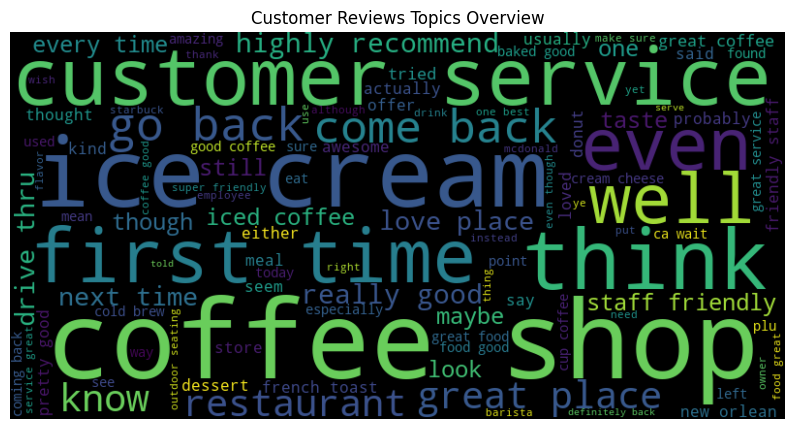

In [46]:
# Combine all reviews into a single string
all_reviews = ' '.join(df_reviews['text'].astype(str))

# Tokenize the text into words
words = word_tokenize(all_reviews)

# Remove stopwords
stop_words = set(stopwords.words('english'))
words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

# Join the processed words into a string
processed_text = ' '.join(words)

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, max_words = 100).generate(processed_text)

# Display the WordCloud using Matplotlib
plt.figure(figsize=(10, 10))
plt.title("Customer Reviews Topics Overview")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Observations:
1. There are many phrases related to customer service, such as: customer service, staff friendly, service great, friendly staff. This indicates that customer service and the behavior of staff towards customers is considered an important factor by most reviewers.
2. There are many words related to desserts, such as: dessert, ice cream, donut. This means that good quality desserts, especially ice cream is another important factor for customer satisfaction.
3. From the frequent appearance of words in comments such as: good/great food/coffee/place, really good, awesome, great service and the lack of negative comments in the wordcloud we could assume that the majority of the reviews are positive. 

#### We will use TextBlob to calulate sentiment polarity, which lies in [-1,1] , where 1 means positive sentiment and -1 means negative sentiment.

In [47]:
# calculate sentiment polarity and store it in new column
df_reviews['polarity'] = df_reviews['text'].map(lambda text: TextBlob(text).sentiment.polarity)

##### We plot a histogram that shows the reviews sentiment polarity distribution.

In [65]:
# plot histogram using plotly library
fig = px.histogram(df_reviews, x='polarity', title='Reviews Sentiment Polarity Distribution' ,nbins=50, color_discrete_sequence=['orange'])
fig.update_traces(marker_line_color='black', marker_line_width=1.5)
fig.show(renderer="browser")

### The majority of sentiment polarity of scores are greater than zero , which means most of  reviews are pretty positive.

##### We plot a histogram that shows review rating distribution. This can give us information about whether review ratings are in align with polarity score.

In [69]:
# plot histogram with plotly
fig = px.histogram(df_reviews, x='review_stars', title='Review Rating Distribution', color_discrete_sequence=['orange'] )
fig.update_traces(marker_line_color='black', marker_line_width=1.5)
fig.show(renderer='browser')

### The ratings are in align with the polarity score, that is, most of the ratings are pretty high at 4 or 5 ranges. 

#### Export cleaned reviews dataframe to csv and store it to AWS S3 to apply topic modelling later

In [ ]:
#Define path to store cleaned csv file with reviews
reviews_path = 'YelpData/reviews_topic_modelling.csv'

# Call function to convert reviews dataframe to csv and store it to S3 bucket
export_csv_to_S3(df_reviews, reviews_path)